In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot


sns.set_theme(style="dark")
# pd.options.display.float_format = '{:,.2f}'.format

### Descrição do problema
Recentemente, a equipe de Growth começou a investir muito dinheiro para aumentar exponencialmente nosso número de pedidos. Porém, durante nossas reuniões de resultado (SDG), notamos que a **avaliação média dos pedidos começou a cair**. Nossa equipe agora tem medo de que, se investir muito dinheiro, as operações não conseguirão lidar com a demanda e prejudicarão o que criamos como marca.

Identifique qual é a **causa raiz do problema** apresentado e informe à equipe se eles **devem interromper todos os investimentos ou se existe um plano B** que eles possam seguir para continuar aumentando os pedidos.

### Informações relevantes
- Em julho de 17, a plataforma na qual a Zé Delivery opera foi alterada para uma nova que desenvolvemos internamente. Isso coincide com o mesmo período em que a classificação do pedido começou a cair.


- O aumento do investimento em marketing começou em agosto de 17.


- Usuários irritados normalmente tendem a avaliar o pedido antes de usuários felizes, porque normalmente retornam à plataforma tentando encontrar uma solução para o problema que possam estar tendo.

### Insights

- % pessoas que não receberam a avaliação aumentou depois da versão nova do app
- Compartilhar conhecimento das melhores lojas com as demais
- Mapeamento de processos (BPMN)
- Investir parte do orçamento também na retenção de usuários (investir em treinamento para as distruibuidoras)



- 55% das pessoas não receberam a avaliação a partir de junho
- Menos de 7% das pessoas não respondem a avaliação
- variação da avaliação de cada POC ao longo do mês aumentou a partir de Julho
- No mês de julho as vendas caem mais que 20% em pelo menos 14 estabelicimentos

## Análise
- Montar ETL com os dados - OK
- Quantos % não receberam a solicitação de classificação? - OK
- Quantos % não responderam a pergunta? qual ticket médio dos produtos? - OK
- Buscar na loja do app os comentários que fizeram. -OK
- Ver se existe correlação entre a nota e a POC - OK
- Ver se existe correlação entre ticket médio e POC - OK
- Ver a correlação entre ticket médio e nota por estado
- Ver a correlação o agrupamento dos emails, ticket médio e nota
- Correlação de horário/número de pedidos e as notas 
- Ver se a nota baixa se comporta ao longo do tempo 
- Ver correlção entre usuário e nota

In [2]:
refined = f'../Datalake/Refined'

In [3]:
data = pd.read_csv(f'{refined}/refined_data.csv', decimal=",")

In [4]:
data['gross_revenue'] = pd.to_numeric(data['gross_revenue'])
data['rating'] = pd.to_numeric(data['rating'])

### Agrupamentos

In [5]:
vendas_semana = data.groupby('week').count()['order_id']
vendas_mes = data.groupby('date_month').count()['order_id']
vendas_dia_semana = data.groupby('date_week_day').count()['order_id']
vendas_hora = data.groupby('date_hour').count()['order_id']

## - % de usuários não receberam a solicitação de classificação?

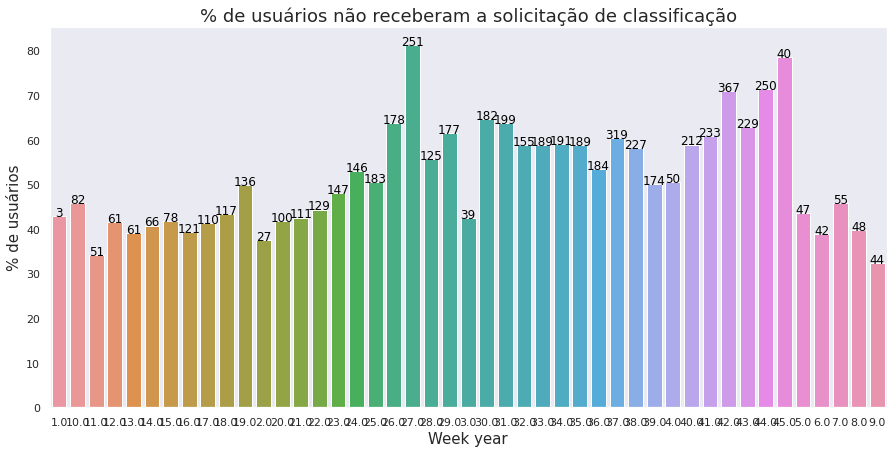

In [6]:
sem_informacao = data[data['rating']== 0].groupby('week').size()
result = pd.Series((sem_informacao.values/vendas_semana.values)*100, index=sem_informacao.index)

fig, ax = plt.subplots(figsize = (15, 7))


g = sns.barplot(x = result.index, y = result.values, ax=ax)
g.axes.set_title("% de usuários não receberam a solicitação de classificação",fontsize=18)
g.set_xlabel("Week year",fontsize=15)
g.set_ylabel("% de usuários",fontsize=15)

count = 0
for index, row in result.iteritems():
    g.text(count, row, sem_informacao.values[count], color='black', ha="center")
    count +=1
plt.show()

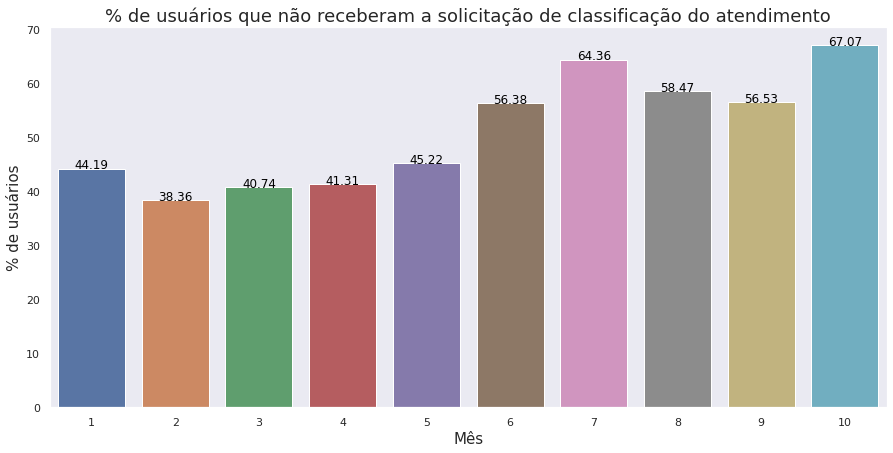

In [7]:
sem_informacao = data[data['rating']== 0].groupby('date_month').size()
result = pd.Series((sem_informacao.values/vendas_mes.values)*100, index=sem_informacao.index)

fig, ax = plt.subplots(figsize = (15, 7))

g = sns.barplot(x = result.index, y = result.values, ax=ax)
g.axes.set_title("% de usuários que não receberam a solicitação de classificação do atendimento",fontsize=18)
g.set_xlabel("Mês",fontsize=15)
g.set_ylabel("% de usuários",fontsize=15)

count = 0
for index, row in result.iteritems():
    g.text(count, row, round(result.values[count],2), color='black', ha="center")
    count +=1
plt.show()

## - % de usuários não responderam a pergunta? 

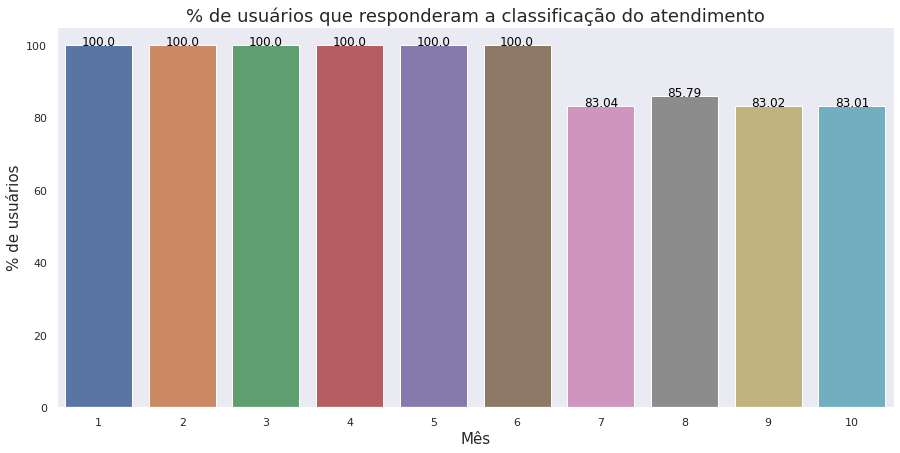

In [8]:
recebeu = data[(data['rating']!= 0.0)].groupby('date_month').size()
respondeu = data[(data['rating']!= -1.0) & (data['rating']!= 0.0)].groupby('date_month').size()

# nao_respondeu = data[(data['rating']!= -1.0) & (data['rating']!= 0.0)].groupby('date_month').size()
result = pd.Series((respondeu.values/recebeu.values)*100, index=recebeu.index)

fig, ax = plt.subplots(figsize = (15, 7))

# sns.barplot(x = result.index, y = result.values, ax=ax)
g = sns.barplot(x = result.index, y = result.values, ax=ax)
g.axes.set_title("% de usuários que responderam a classificação do atendimento",fontsize=18)
g.set_xlabel("Mês",fontsize=15)
g.set_ylabel("% de usuários",fontsize=15)

count = 0
for index, row in result.iteritems():
    g.text(count, row, round(result.values[count],2), color='black', ha="center")
    count +=1
plt.show()

## - Ver se existe correlação entre a nota e a POC

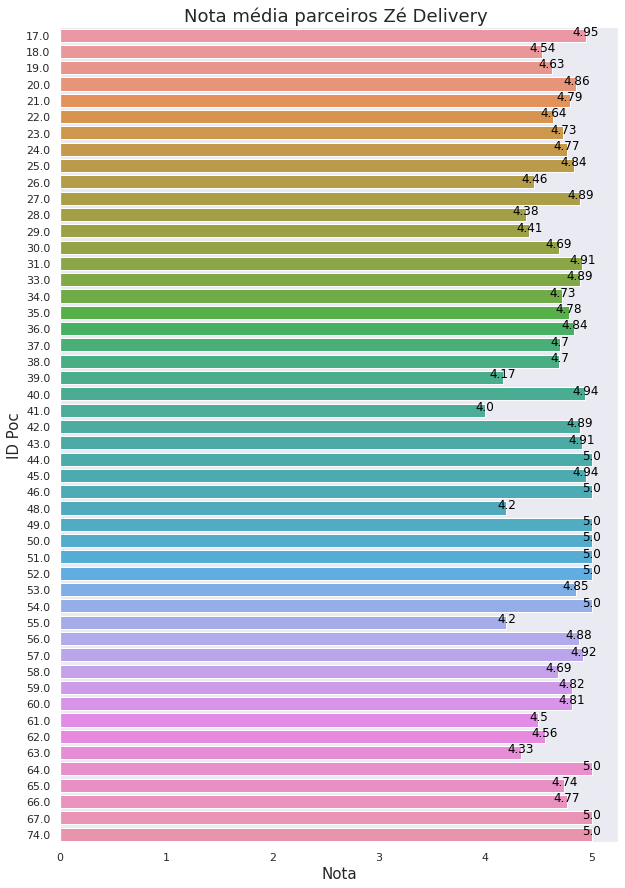

In [9]:
result = data[(data['rating'] != -1.0) & (data['rating'] != 0)].groupby(['poc_id']).mean()['rating']

fig, ax = plt.subplots(figsize = (10, 15))

g = sns.barplot(y = result.index, x = result.values, ax=ax)
g.axes.set_title("Nota média parceiros Zé Delivery ",fontsize=18)
g.set_xlabel("Nota",fontsize=15)
g.set_ylabel("ID Poc",fontsize=15)

count = 0
for index, row in result.iteritems():
    g.text(y = count, x = row, s = round(result.values[count], 2), color='black', ha="center")
    count +=1
plt.show()

In [10]:
result = data[(data['rating'] != -1.0) & (data['rating'] != 0)].groupby(['poc_id', 'date_month']).mean()[['rating']]
result2 = result.reset_index()
result2['pct'] = result2.groupby('poc_id').rating.pct_change()
result2['pct'] = result2.pct * 100
result2

,poc_id,date_month,rating,pct
0,17.0,3,5.000000,NaN
1,17.0,4,5.000000,0.000000
2,17.0,5,4.857143,-2.857143
3,17.0,6,5.000000,2.941176
4,17.0,7,4.705882,-5.882353
...,...,...,...,...
321,66.0,8,4.588235,1.960784
322,66.0,9,4.857143,5.860806
323,66.0,10,4.941176,1.730104
324,67.0,7,5.000000,NaN


In [11]:
result2.pct.quantile([.25, .5, .75])

0.25   -4.299095
0.50    0.000000
0.75    1.955006
Name: pct, dtype: float64

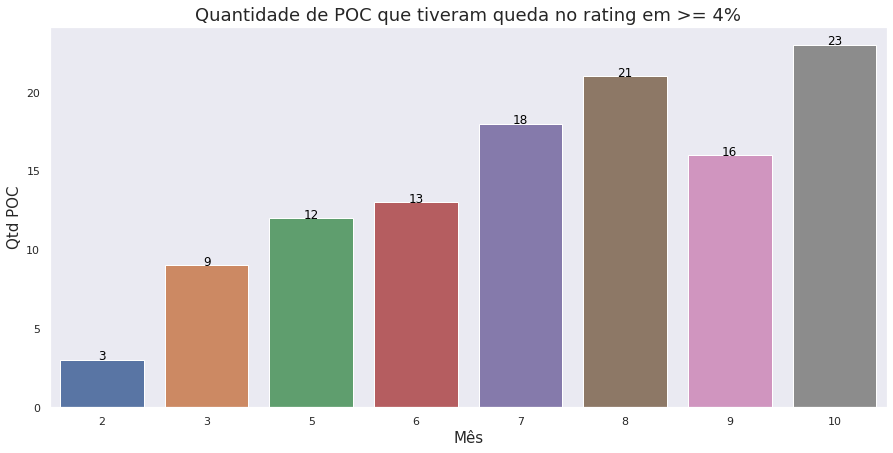

In [61]:
result = result2[result2['pct']<= -4.0].groupby('date_month').size()

fig, ax = plt.subplots(figsize = (15, 7))

g = sns.barplot(x = result.index, y = result.values, ax=ax)
g.axes.set_title("Quantidade de POC que tiveram queda no rating em >= 4%",fontsize=18)
g.set_xlabel("Mês",fontsize=15)
g.set_ylabel("Qtd POC",fontsize=15)

count = 0
for index, row in result.iteritems():
    g.text(count, row, result.values[count], color='black', ha="center")
    count +=1
plt.show()

## - Ver se existe correlação entre ticket médio e POC

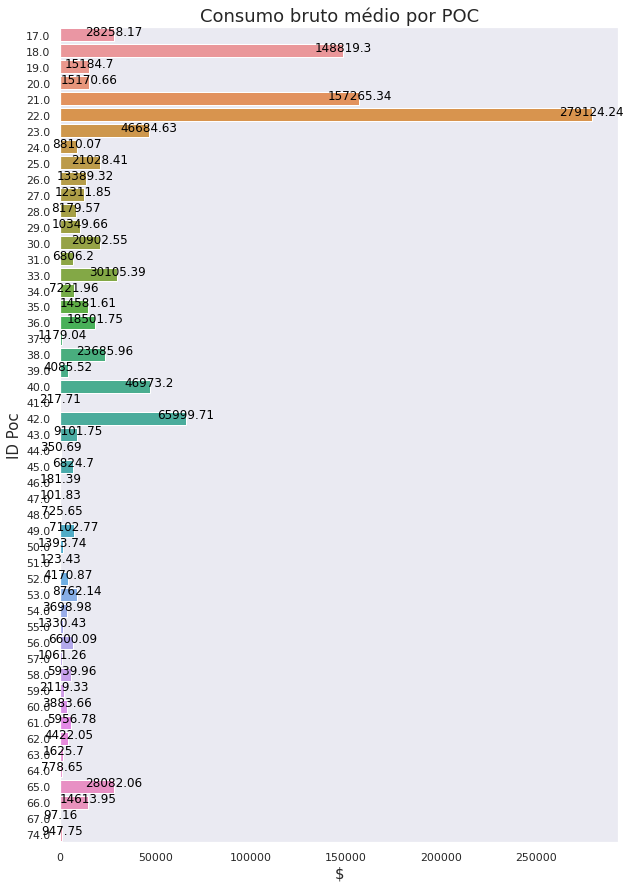

In [13]:
result = data.groupby(['poc_id']).sum()['gross_revenue']

fig, ax = plt.subplots(figsize = (10, 15))

g = sns.barplot(y = result.index, x = result.values, ax=ax)
g.axes.set_title("Consumo bruto médio por POC",fontsize=18)
g.set_xlabel("$",fontsize=15)
g.set_ylabel("ID Poc",fontsize=15)

count = 0
for index, row in result.iteritems():
    g.text(y = count, x = row, s = round(result.values[count], 2), color='black', ha="center")
    count +=1
plt.show()

In [14]:
result = data.groupby(['poc_id', 'date_month']).sum()[['gross_revenue']]
result2 = result.reset_index()
result2['pct'] = result2.groupby('poc_id').gross_revenue.pct_change()
result2['pct'] = result2.pct * 100
result2

,poc_id,date_month,gross_revenue,pct
0,17.0,3,1033.336,NaN
1,17.0,4,2398.736,132.135143
2,17.0,5,5699.376,137.599136
3,17.0,6,3443.840,-39.575139
4,17.0,7,3290.168,-4.462228
...,...,...,...,...
344,66.0,9,2572.472,3.646127
345,66.0,10,1865.600,-27.478317
346,67.0,7,97.160,NaN
347,74.0,9,675.792,NaN


In [15]:
result2.pct.quantile([.25, .5, .75])

0.25   -20.338978
0.50    13.126144
0.75    83.635074
Name: pct, dtype: float64

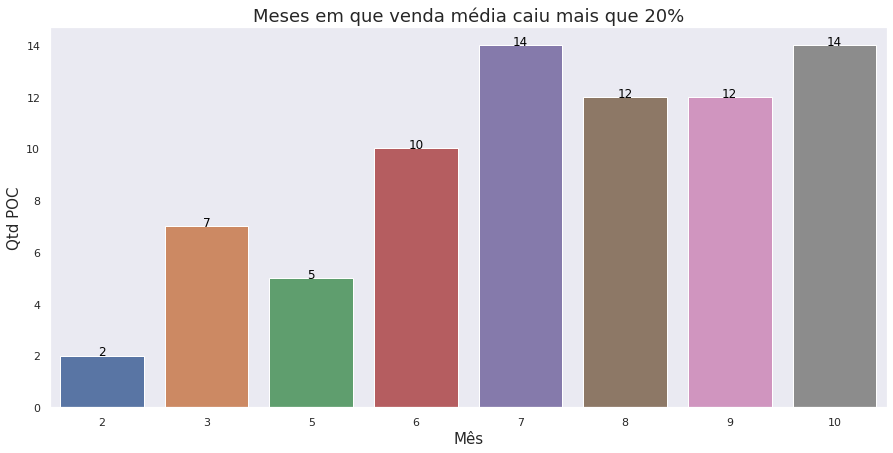

In [16]:
result = result2[result2['pct']<= -20.0].groupby('date_month').size()

fig, ax = plt.subplots(figsize = (15, 7))

g = sns.barplot(x = result.index, y = result.values, ax=ax)
g.axes.set_title("Meses em que venda média caiu mais que 20%",fontsize=18)
g.set_xlabel("Mês",fontsize=15)
g.set_ylabel("Qtd POC",fontsize=15)

count = 0
for index, row in result.iteritems():
    g.text(count, row, result.values[count], color='black', ha="center")
    count +=1
plt.show()

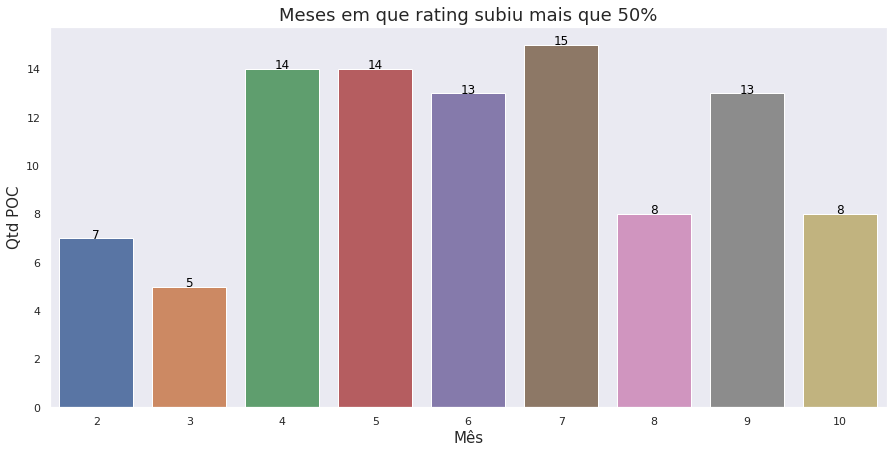

In [17]:
result = result2[result2['pct']>= 50].groupby('date_month').size()

fig, ax = plt.subplots(figsize = (15, 7))

g = sns.barplot(x = result.index, y = result.values, ax=ax)
g.axes.set_title("Meses em que rating subiu mais que 50%",fontsize=18)
g.set_xlabel("Mês",fontsize=15)
g.set_ylabel("Qtd POC",fontsize=15)

count = 0
for index, row in result.iteritems():
    g.text(count, row, result.values[count], color='black', ha="center")
    count +=1
plt.show()

In [21]:
data.head()

,order_id,order_number,week,comment,user,gross_revenue,payment_method,poc_id,rating,shipping_type,state,rating_datetime,rating_reasons,date_time,date_week_day,date_day,date_month,date_day_of_year,date_hour,date_day_month
0,191357.0,14027.0,1.0,sem comentario,user7gmail.com,105.120,sem informação,26.0,5.0,receber,SP,NaN,NaN,2017-01-01 10:11:01,6,1,1,1,10,01-01
1,191361.0,14031.0,1.0,sem comentario,user11gmail.com,70.848,sem informação,30.0,5.0,receber,SP,NaN,NaN,2017-01-01 11:39:28,6,1,1,1,11,01-01
2,191362.0,14032.0,1.0,sem comentario,user12gmail.com,62.304,sem informação,26.0,0.0,receber,SP,NaN,NaN,2017-01-01 12:22:29,6,1,1,1,12,01-01
3,191384.0,14054.0,1.0,sem comentario,user33gmail.com,48.816,sem informação,29.0,1.0,receber,SP,NaN,NaN,2017-01-01 15:35:10,6,1,1,1,15,01-01
4,191385.0,14055.0,1.0,sem comentario,user34gmail.com,70.848,sem informação,30.0,5.0,receber,SP,NaN,NaN,2017-01-01 16:02:38,6,1,1,1,16,01-01


<AxesSubplot:xlabel='date_month'>

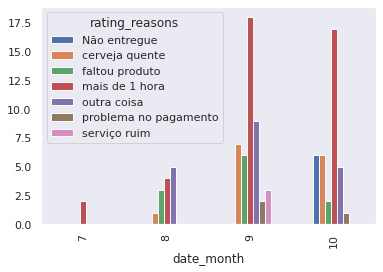

In [59]:
pd.crosstab(data['date_month'], data[data['rating_reasons'] != 'sem informacao motivo'].rating_reasons).plot.bar()

In [60]:
result = pd.crosstab(data['date_month'], data[data['rating_reasons'] != 'sem informacao motivo'].rating_reasons)
result

rating_reasons,Não entregue,cerveja quente,faltou produto,mais de 1 hora,outra coisa,problema no pagamento,serviço ruim
date_month,,,,,,,
7,0,0,0,2,0,0,0
8,0,1,3,4,5,0,0
9,0,7,6,18,9,2,3
10,6,6,2,17,5,1,0


In [62]:
data.head()

,order_id,order_number,week,comment,user,gross_revenue,payment_method,poc_id,rating,shipping_type,state,rating_datetime,rating_reasons,date_time,date_week_day,date_day,date_month,date_day_of_year,date_hour,date_day_month
0,191357.0,14027.0,1.0,sem comentario,user7gmail.com,105.120,sem informação,26.0,5.0,receber,SP,NaN,NaN,2017-01-01 10:11:01,6,1,1,1,10,01-01
1,191361.0,14031.0,1.0,sem comentario,user11gmail.com,70.848,sem informação,30.0,5.0,receber,SP,NaN,NaN,2017-01-01 11:39:28,6,1,1,1,11,01-01
2,191362.0,14032.0,1.0,sem comentario,user12gmail.com,62.304,sem informação,26.0,0.0,receber,SP,NaN,NaN,2017-01-01 12:22:29,6,1,1,1,12,01-01
3,191384.0,14054.0,1.0,sem comentario,user33gmail.com,48.816,sem informação,29.0,1.0,receber,SP,NaN,NaN,2017-01-01 15:35:10,6,1,1,1,15,01-01
4,191385.0,14055.0,1.0,sem comentario,user34gmail.com,70.848,sem informação,30.0,5.0,receber,SP,NaN,NaN,2017-01-01 16:02:38,6,1,1,1,16,01-01


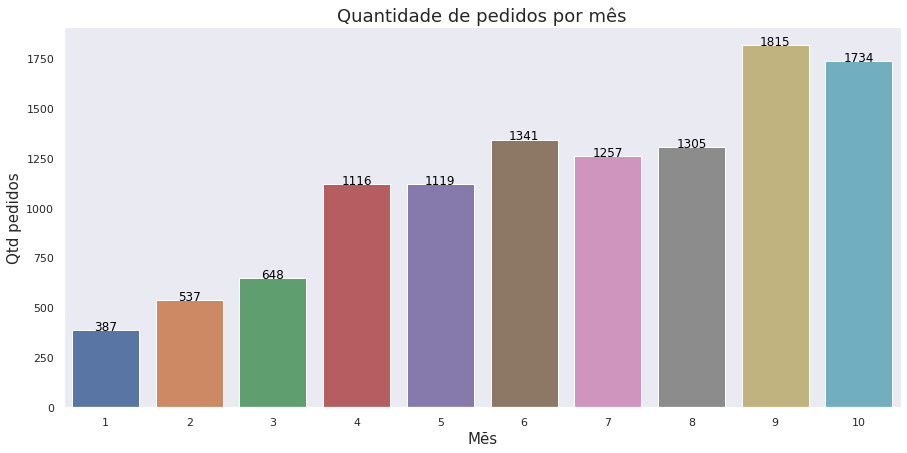

In [65]:
result = data.groupby('date_month').size()

fig, ax = plt.subplots(figsize = (15, 7))

g = sns.barplot(x = result.index, y = result.values, ax=ax)
g.axes.set_title("Quantidade de pedidos por mês",fontsize=18)
g.set_xlabel("Mẽs",fontsize=15)
g.set_ylabel("Qtd pedidos",fontsize=15)

count = 0
for index, row in result.iteritems():
    g.text(count, row, result.values[count], color='black', ha="center")
    count +=1
plt.show()